In [27]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from common_utils import EmbeddingMatrix, UNK_TOKEN, EMBEDDING_DIM, tokenize
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
np.random.seed(42)
torch.manual_seed(0)

# make sure to generate with part_3_tk.ipynb first
# todo merge with previous parts

In [28]:
# Load word2vec embedding matrix
w2v_model = EmbeddingMatrix.load()
word2idx = w2v_model.word2idx

In [29]:
# Load datasets
from datasets import load_dataset
# From assignment PDF
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset ['train']
validation_dataset = dataset ['validation']
test_dataset = dataset ['test']


In [33]:
import datasets
import nltk

def tokenize(texts, word2idx, max_len=512):
    tokenized = []
    for text in texts:
        tokens = nltk.word_tokenize(text.lower())
        token_ids = [word2idx.get(word, word2idx[UNK_TOKEN]) for word in tokens]
        tokenized.append(torch.tensor(token_ids[:max_len], dtype=torch.int))
    return tokenized


def prepare_dataset(dataset: datasets.DatasetDict, batch_size=50) -> torch.utils.data:
    set_tokenized = tokenize(dataset['text'], word2idx)

    set_tokenized = pad_sequence(set_tokenized, batch_first=True)

    set_labels = torch.tensor(dataset['label'])

    set_data = data.TensorDataset(set_tokenized, set_labels)

    return data.DataLoader(set_data, batch_size, shuffle=True)
train_loader = prepare_dataset(train_dataset)
val_loader = prepare_dataset(validation_dataset)
test_loader = prepare_dataset(test_dataset)

# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


## 3(c) biLSTM

In [34]:
class BiLSTM(nn.Module):
    def __init__(self, word_embedding, hidden_dim, embedding_dim):
        super(BiLSTM, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(word_embedding, dtype=torch.float))

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        # Fully connected layer for binary classification
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embed the input sequence
        embedded = self.embedding(x)

        # Apply the BiLSTM layer
        emb_output, (hidden_state,cell_state) = self.lstm(embedded)

         # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        hidden = self.dropout(hidden)
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.sigmoid(dense_outputs)
        
        return outputs

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim = 64
# batch_size = 64
max_norm = 5
learning_rate = 0.0001
epochs = 100
es_patience = 15

# Create LSTM model
model = BiLSTM(w2v_model.embedding_matrix,hidden_dim,w2v_model.dimension)
print(model)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Create loss function
loss_fn = nn.BCELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

BiLSTM(
  (embedding): Embedding(16164, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [36]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label).item()

# training
def train_loop(train_loader, model, loss_fn, optimizer, max_norm = 3):
    train_loss = []
    train_acc = 0.0
    model.train()
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)   

        optimizer.zero_grad()
        output = model(X)
        
        # calculate the loss and perform backprop
        loss = loss_fn(output.squeeze(), Y.float())
        loss.backward()
        train_loss.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,Y)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = train_acc/len(train_loader.dataset)

    return epoch_train_loss, epoch_train_acc

# testing
def test_loop(test_loader, model, loss_fn):

    test_loss = []
    test_acc = 0.0
    model.eval() # inform no dropout and fix bn during testing
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)   

            optimizer.zero_grad()
            output = model(X)
            
            # calculate the loss and perform backprop
            loss = loss_fn(output.squeeze(), Y.float())

            test_loss.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,Y)
            test_acc += accuracy

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = test_acc/len(test_loader.dataset)

    return epoch_test_loss, epoch_test_acc

In [37]:
best_val_loss = np.inf
best_acc = 0
train_loss_, train_acc_, val_loss_, val_acc_ = [], [], [], []
from tqdm import tqdm
# start training
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test_loop(val_loader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    val_loss_.append(val_loss), val_acc_.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= es_patience:
            print(f'early stopping after {epoch+1} epochs')
            print(f'best val loss: {best_val_loss}')
            print(f'best accuracy on val set: {best_acc}')
            break

    if epoch % 10 == 0:
        print(f"epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, val_loss {val_loss:>7f}, val_acc {val_acc:>4f}")

  1%|          | 1/100 [00:00<01:25,  1.15it/s]

epoch 1, train_loss 0.692091 train_acc 0.514654, val_loss 0.689957, val_acc 0.545966


 11%|█         | 11/100 [00:08<01:01,  1.45it/s]

epoch 11, train_loss 0.507107 train_acc 0.755451, val_loss 0.543875, val_acc 0.725141


 21%|██        | 21/100 [00:14<00:52,  1.50it/s]

epoch 21, train_loss 0.453045 train_acc 0.788863, val_loss 0.513909, val_acc 0.748593


 31%|███       | 31/100 [00:21<00:45,  1.51it/s]

epoch 31, train_loss 0.423876 train_acc 0.802814, val_loss 0.514874, val_acc 0.748593


 41%|████      | 41/100 [00:27<00:39,  1.51it/s]

epoch 41, train_loss 0.386391 train_acc 0.824853, val_loss 0.520094, val_acc 0.762664


 42%|████▏     | 42/100 [00:29<00:40,  1.44it/s]

early stopping after 43 epochs
best val loss: 0.49854412945834076
best accuracy on val set: 0.7664165103189493


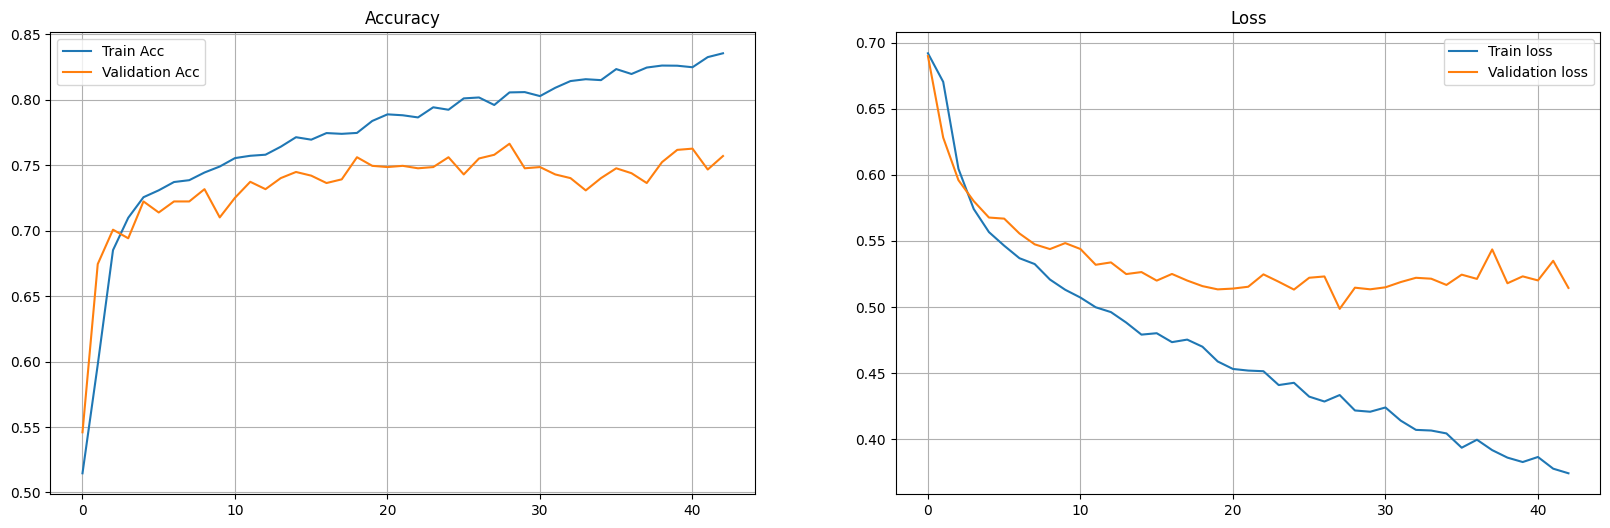

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_, label='Train Acc')
plt.plot(val_acc_, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(train_loss_, label='Train loss')
plt.plot(val_loss_, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [39]:
test_loss, test_acc = test_loop(test_loader, model, loss_fn)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

test_loss 0.502771, test_acc 0.757036


# Question 3. Enhancement
(a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).
   
(b) Report the accuracy score on the test set when applying your method to deal with OOV words
in Part 3.2.
   
(c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).
   
(d) Report the accuracy scores of CNN on the test set (Part 3.4).
   
(e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set
using your improved model.
   
(f) Compare the results across different solutions above and describe your observations with possible discussions.
